# EDA для розничной сети магазинов

**Цели проекта:**
- Изучить структуру и особенности исходных данных (магазины, продажи, внешние факторы)
- Проанализировать динамику продаж по времени и выявить сезонность
- Оценить влияние праздничных недель на объем продаж
- Исследовать возможную связь макроэкономических факторов (цены на топливо, CPI, безработица) с уровнем продаж в розничной сети

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

## Загрузка данных

In [2]:
features = pd.read_csv('Features data set.csv')
sales = pd.read_csv('sales data-set.csv')
stores = pd.read_csv('stores data-set.csv')

Подробнее изучим данные в каждом датасете


### Features

In [3]:
features.head(3)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False


Описание: внешние факторы и информация о скидках на уровне магазина и даты

- Store — номер магазина
- Date — неделя наблюдения (формат даты)
- Temperature — средняя температура в регионе магазина (в градусах Фаренгейта)
- Fuel_Price — средняя цена топлива в регионе (в долларах)
- MarkDown1–MarkDown5 — пять разных анонимных показателей по скидкам и промо-акциям. Доступны только с ноября 2011 года. Много пропусков (NA), особенно до ноября 2011 года
- CPI — индекс потребительских цен (Consumer Price Index) в регионе
- Unemployment — уровень безработицы в регионе (в процентах)
- IsHoliday — является ли неделя праздничной (True/False)

### Stores

In [4]:
stores.head(3)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392


Описание: информация о каждом магазине

- Store — уникальный номер магазина
- Type — тип магазина
- Size — размер магазина

### Sales

In [5]:
sales.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False


Описание: исторические данные о продажах по каждому магазину и департаменту

- Store — номер магазина
- Dept — номер департамента
- Date — неделя продажи
- Weekly_Sales — сумма продаж за неделю в этом магазине и департаменте (в долларах)
- IsHoliday — является ли неделя праздничной


Теперь рассмотрим долю пропусков в каждом датасете.

In [6]:
# функция для опрееделения доли пропусков и размера датасета
def check_df(df, name):
    print(f"==={name}===")
    print('shape:', df.shape)
    print('missing share:')
    print(df.isna().mean())
    print()

check_df(stores, 'Stores')
check_df(features, 'Features')
check_df(sales, 'Sales')

===Stores===
shape: (45, 3)
missing share:
Store    0.0
Type     0.0
Size     0.0
dtype: float64

===Features===
shape: (8190, 12)
missing share:
Store           0.000000
Date            0.000000
Temperature     0.000000
Fuel_Price      0.000000
MarkDown1       0.507692
MarkDown2       0.643346
MarkDown3       0.558852
MarkDown4       0.577045
MarkDown5       0.505495
CPI             0.071429
Unemployment    0.071429
IsHoliday       0.000000
dtype: float64

===Sales===
shape: (421570, 5)
missing share:
Store           0.0
Dept            0.0
Date            0.0
Weekly_Sales    0.0
IsHoliday       0.0
dtype: float64



**Вывод:**
- Значительная доля пропусков наблюдается в датафрейме Features, в остальных датафреймах - пропусков нет
- Пропуски, в основном, в колонках MarkDown1–MarkDown5. Причина пропусков в том, что данные по этим признакам доступны только с ноября 2011 года. Много пропусков, особенно до ноября 2011 года

## Предобработка

In [7]:
features['Date'] = pd.to_datetime(features['Date'], format='%d/%m/%Y')
sales['Date'] = pd.to_datetime(sales['Date'], format='%d/%m/%Y')

features['IsHoliday'] = features['IsHoliday'].astype(bool)
sales['IsHoliday'] = sales['IsHoliday'].astype(bool)

In [8]:
sales_stores = sales.merge(stores, how='left', on='Store')
df = sales_stores.merge(features, how='left', on=['Store', 'Date', 'IsHoliday'])

df.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106


## Первичная разведка данных

Сколько существует магазинов и департментов?

In [9]:
print(f"У нас {df['Store'].nunique()} уникальных магазинов и {df['Dept'].nunique()} уникальный департамент")

У нас 45 уникальных магазинов и 81 уникальный департамент


Как распределены магазины по размеру?

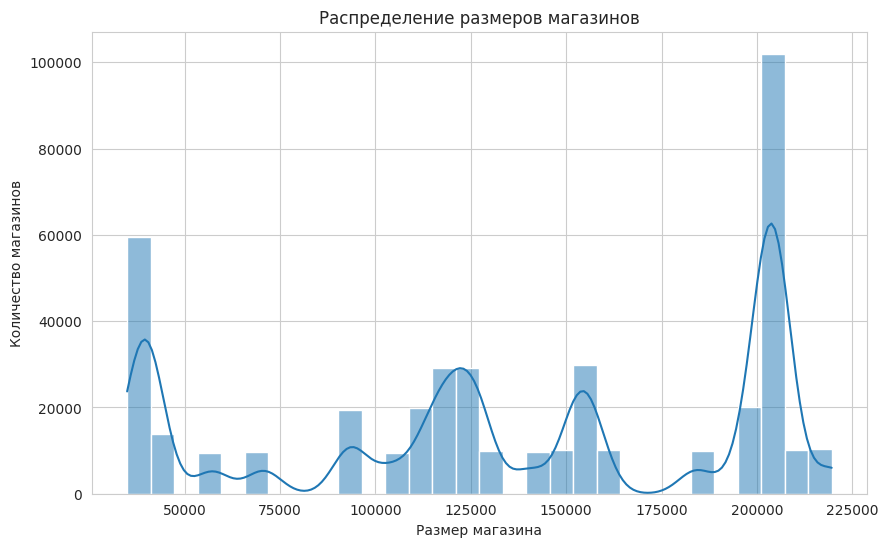

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(df['Size'], bins=30, kde=True)
plt.title('Распределение размеров магазинов')
plt.xlabel('Размер магазина')
plt.ylabel('Количество магазинов')
plt.show()

**Вывод:** Видим два полярных пика. Таким образом, распространены очень большие и очень маленькие магазины.

Как распределены магазины по типу?

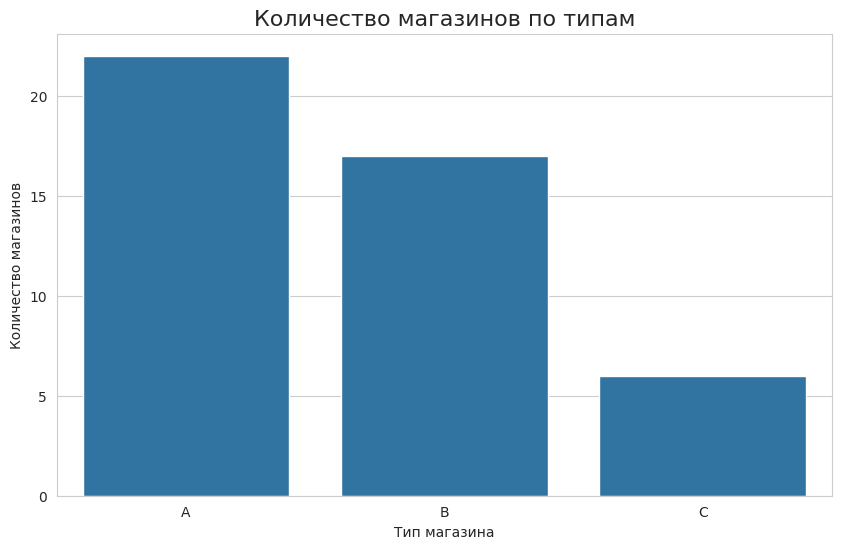

In [11]:
plt.figure(figsize=(10,6))
type_counts = df[['Store', 'Type']].drop_duplicates()['Type'].value_counts()

sns.barplot(x=type_counts.index, y=type_counts.values)
plt.title('Количество магазинов по типам', fontsize=16)
plt.xlabel('Тип магазина')
plt.ylabel('Количество магазинов')
plt.show()

**Вывод:** больше всего магазинов типа А, меньше всего - типа C

## Анализ продаж

### Есть ли сезонность в продажах?

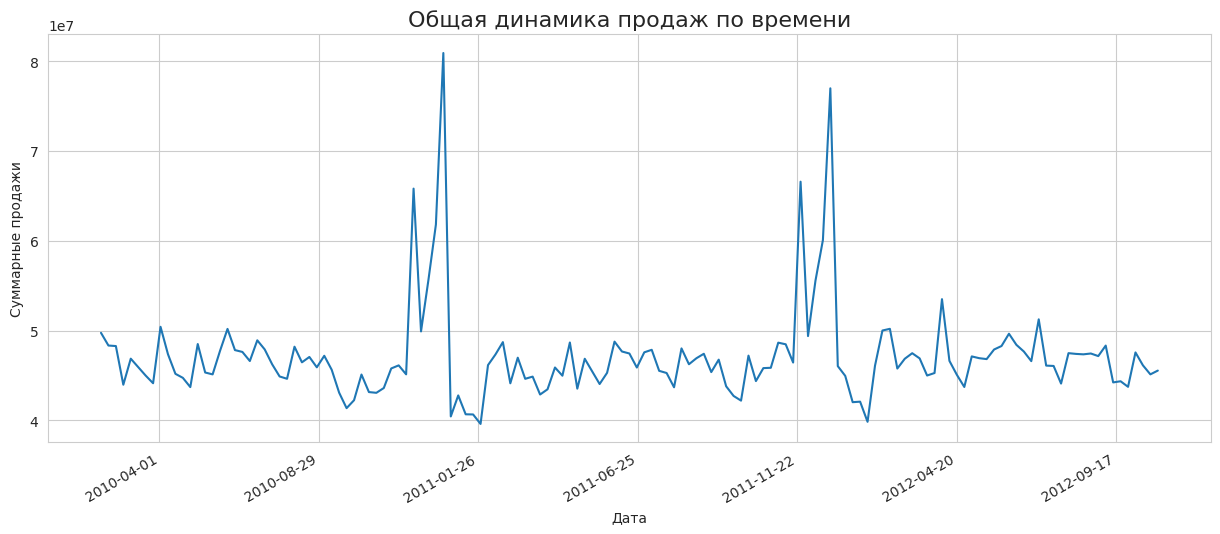

In [12]:
sales_by_date = df.groupby('Date')['Weekly_Sales'].sum().reset_index().sort_values(by='Date')

plt.figure(figsize=(15,6))
sns.lineplot(data=sales_by_date, x='Date', y='Weekly_Sales')
plt.title('Общая динамика продаж по времени', fontsize=16)
plt.xlabel('Дата')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # показывать только 10 дат
plt.gcf().autofmt_xdate()
plt.ylabel('Суммарные продажи')
plt.show()

**Вывод:**
- Продажи стабильные большую часть года на уровне 40–50 млн c некоторой волатильностью
- В конце года (ноябрь-декабрь) всегда наблюдается максимальный рост продаж

### Есть ли зависимость между продажами и фактом праздничной недели?

In [13]:
holiday_weeks = df[df['IsHoliday'] == True]['Date'].drop_duplicates().sort_values()
holiday_weeks

,Date
1,2010-02-12
31,2010-09-10
42,2010-11-26
47,2010-12-31
53,2011-02-11
83,2011-09-09
94,2011-11-25
99,2011-12-30
105,2012-02-10
135,2012-09-07


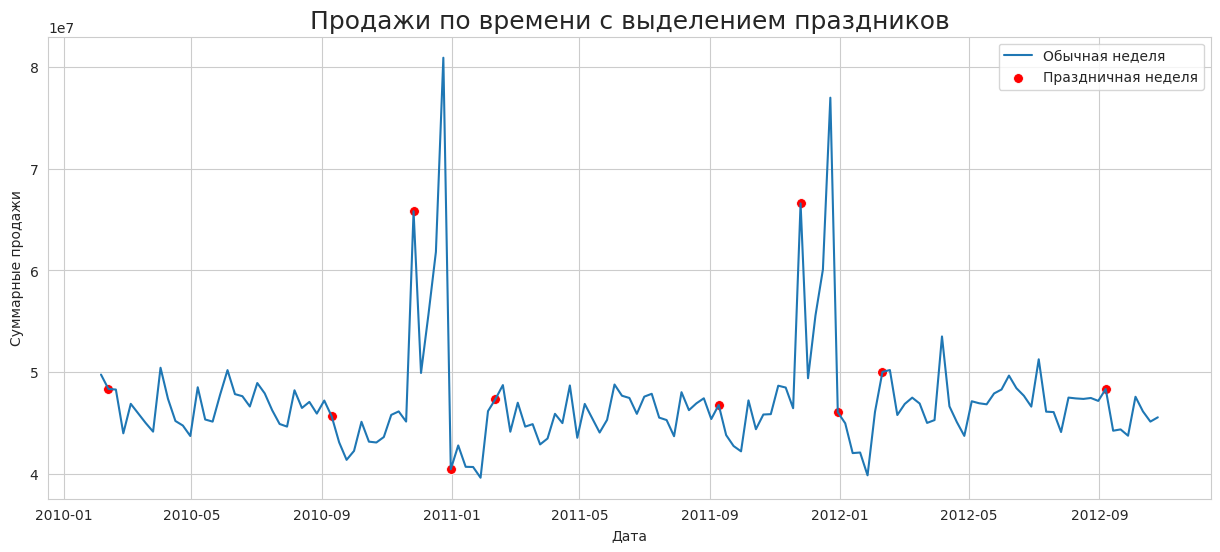

In [14]:
sales_by_date['IsHoliday'] = sales_by_date['Date'].isin(holiday_weeks)

plt.figure(figsize=(15,6))
sns.lineplot(data=sales_by_date, x='Date', y='Weekly_Sales', label='Обычная неделя')
sns.scatterplot(data=sales_by_date[sales_by_date['IsHoliday']],
                x='Date', y='Weekly_Sales',
                color='red', s=50, label='Праздничная неделя')
plt.title('Продажи по времени с выделением праздников', fontsize=18)
plt.xlabel('Дата')
plt.ylabel('Суммарные продажи')
plt.legend()
plt.show()


**Вывод:** кроме одной недели в году, продажи не меняются от факта праздничной недели

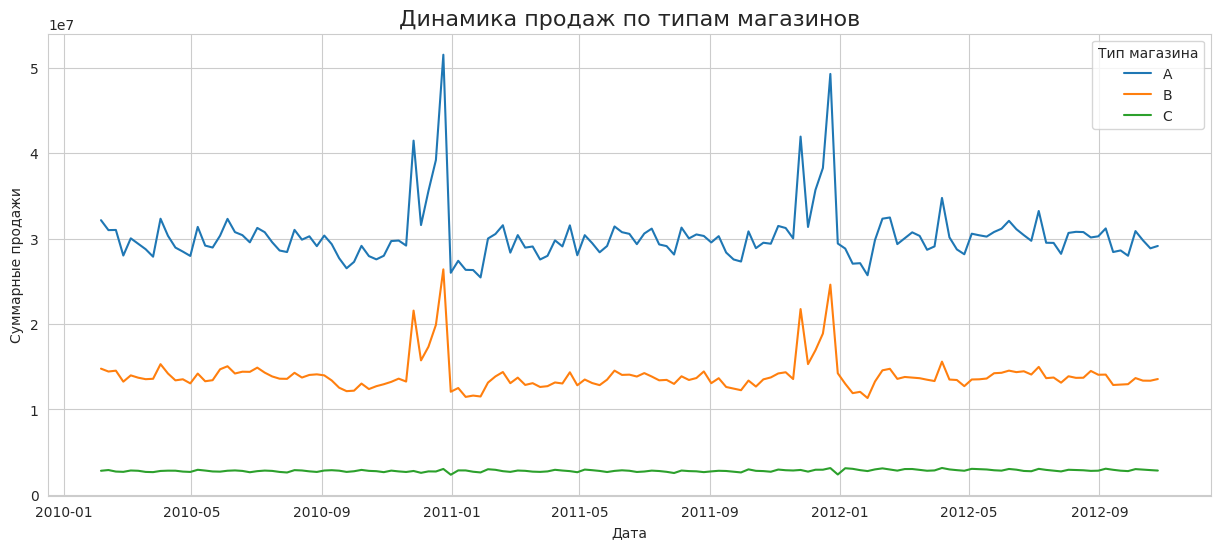

In [15]:
sales_by_type = df.groupby(['Type', 'Date'])['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(15,6))
sns.lineplot(data=sales_by_type, x='Date', y='Weekly_Sales', hue='Type')
plt.title('Динамика продаж по типам магазинов', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Суммарные продажи')
plt.legend(title='Тип магазина')
plt.show()

**Вывод:**
- магазины типа A и B имеют волатильность и пики в динамике продаж, которые мы определили ранее
- при этом магазин типа C практически не приносит продаж (по сравнению с другими типами) и совсем не чувствителен к сезонности в продажах

### Есть ли связь между размером магазина и суммарными продажами?

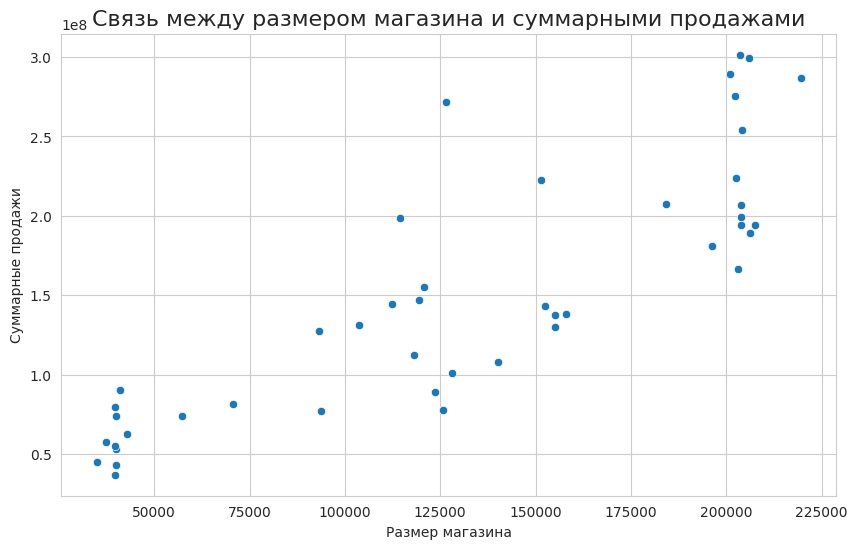

In [16]:
store_info = df.groupby('Store').agg({
    'Weekly_Sales': 'sum',
    'Size': 'first'
}).reset_index()

plt.figure(figsize=(10,6))
sns.scatterplot(data=store_info, x='Size', y='Weekly_Sales')
plt.title('Связь между размером магазина и суммарными продажами', fontsize=16)
plt.xlabel('Размер магазина')
plt.ylabel('Суммарные продажи')
plt.grid(True)
plt.show()

**Вывод:**
- В целом, большие магазины действительно приносят больше продаж
- С увеличением размера магазина, увеличиваются суммарные продажи

In [17]:
store_info['Size'].corr(store_info['Weekly_Sales'])

np.float64(0.846161245171892)

**Вывод:** Корреляция между размером магазина и суммарными продажами - сильная положительная

### Анализ влияния макроэкономических факторов

Факторы, которые будем анализировать:

- Temperature — средняя температура

- Fuel_Price — цена на топливо

- CPI — индекс потребительских цен

- Unemployment — уровень безработицы

Сначала изучим динамику самих макроэкономических показателей.

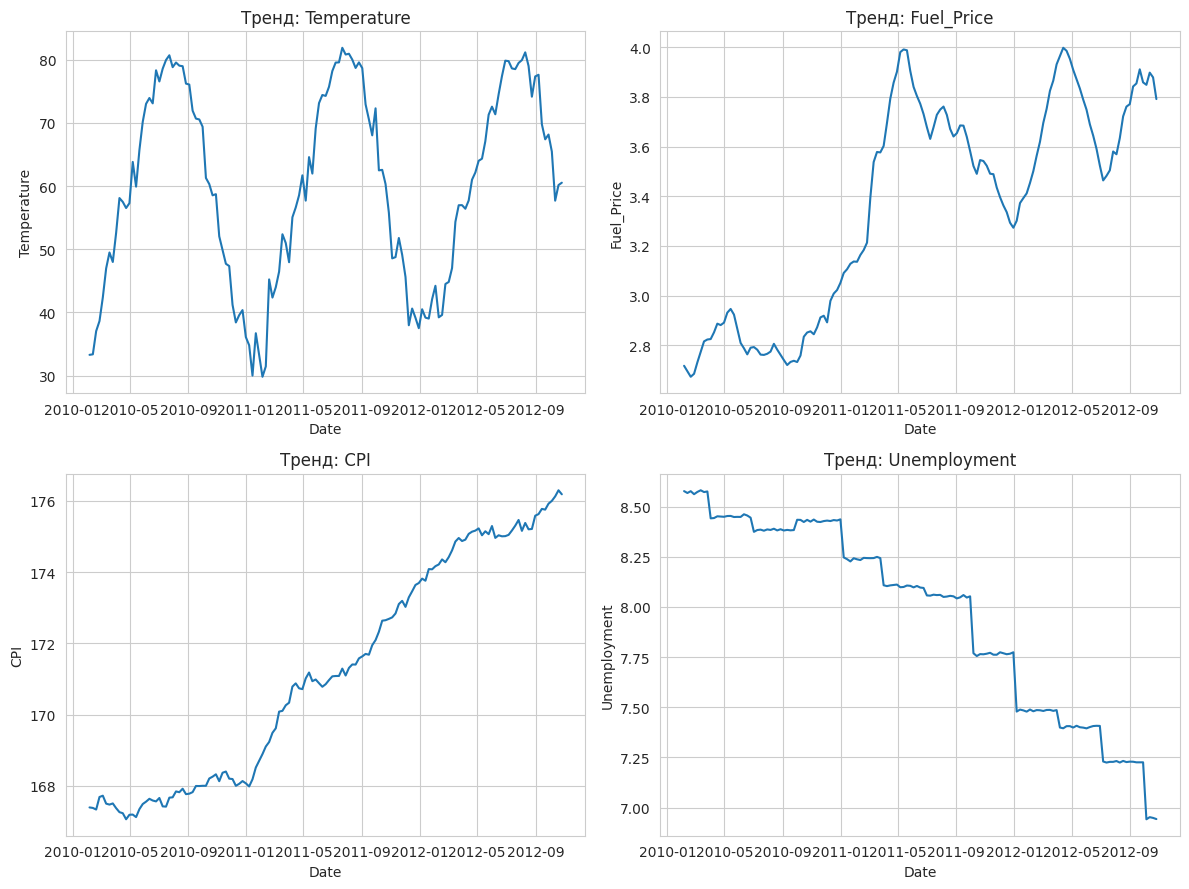

In [18]:
macro_trends = df.groupby('Date')[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales']].mean().reset_index()

fig, axes = plt.subplots(2, 2, figsize=(12, 9))

for idx, col in enumerate(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']):
    row = idx // 2
    col_idx = idx % 2
    sns.lineplot(data=macro_trends, x='Date', y=col, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Тренд: {col}')

plt.tight_layout()
plt.show()

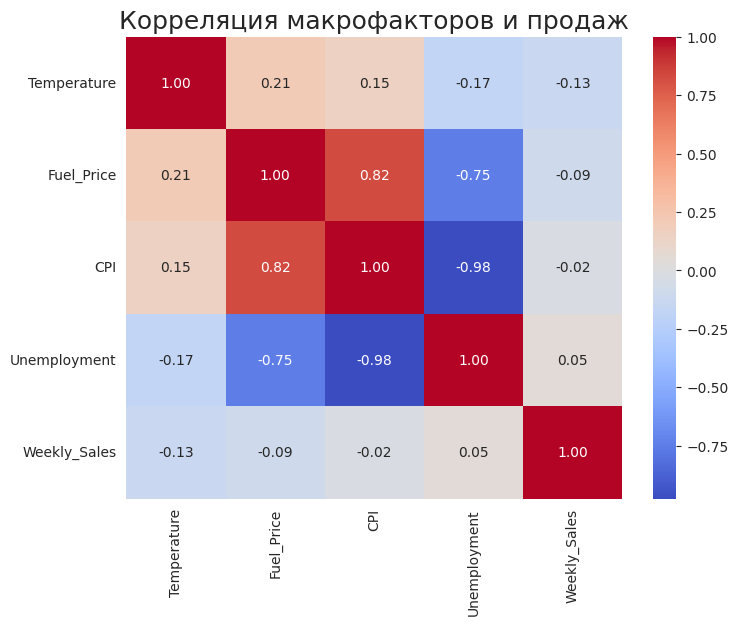

In [19]:
corrs_trends = macro_trends[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corrs_trends, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляция макрофакторов и продаж', fontsize=18)
plt.show()

**Вывод:** корреляции между недельными продажами и макрофакторами низкие. Линейной связи нет.

### Сравнение продаж в разные недели (T-test)

In [20]:
holiday_mean = df[df['IsHoliday'] == True]['Weekly_Sales'].mean()
normal_mean = df[df['IsHoliday'] == False]['Weekly_Sales'].mean()

print(f"Средние продажи в праздничные недели: {holiday_mean:,.2f}")
print(f"Средние продажи в обычные недели: {normal_mean:,.2f}")

Средние продажи в праздничные недели: 17,035.82
Средние продажи в обычные недели: 15,901.45


In [21]:
print(f"Прирост продаж в праздничные недели: {(holiday_mean - normal_mean) / normal_mean * 100:.2f}%")

Прирост продаж в праздничные недели: 7.13%


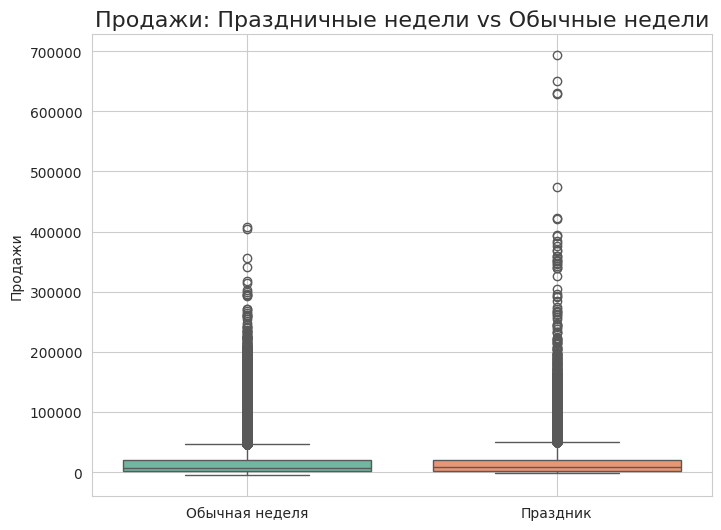

In [22]:
df['Holiday_Flag'] = df['IsHoliday'].map({True: 'Праздник', False: 'Обычная неделя'})

plt.figure(figsize=(8,6))
sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=df, palette='Set2')
plt.title('Продажи: Праздничные недели vs Обычные недели', fontsize=16)
plt.xlabel('')
plt.ylabel('Продажи')
plt.grid(True)
plt.show()

Проведем t-тест

- H0: средние продажи одинаковые;
- H1: продажи в праздники выше.

Сначала проверим гипотезу о равенстве дисперсий с помощью теста Левена

In [23]:
stat_levene, p_levene = levene(
    df[df['IsHoliday'] == True]['Weekly_Sales'],
    df[df['IsHoliday'] == False]['Weekly_Sales']
)

print(f"p-value Левена: {p_levene:.5f}")

p-value Левена: 0.00000


При любом уровне значимости, считаем, что дисперсии НЕ равны. Поэтому используем t-test с условием неравенства дисперсий.

In [24]:
t, p_value = ttest_ind(
    df[df['IsHoliday'] == True]['Weekly_Sales'],
    df[df['IsHoliday'] == False]['Weekly_Sales'],
    equal_var=True)

print(f"t-статистика: {t:.2f}")
print(f"p-value: {p_value:.5f}")

t-статистика: 8.29
p-value: 0.00000


**Вывод:**
- Нулевая гипотеза о равенстве средних продаж в праздники и обычные недели **отвергается** при любом уровне значимости, поскольку `p-value` = 0.000
- праздники действительно статистически значимо увеличивают продажи

## Общий вывод

- Продажи демонстрируют ярко выраженную сезонность с пиками в праздничные недели, особенно в ноябре и декабре
- Праздничные недели статистически значимо увеличивают продажи по сравнению с обычными неделями
- Большие магазины, как правило, имеют выше общий объем продаж
- Макроэкономические факторы (топливо, CPI, безработица) показывают очень слабую связь с динамикой продаж в сети